Answering the question:

## Are scores at given accuracy constant across datasets?

## Can this consistently be filtered through a GMM approach ?

In [1]:
from denovo_utils.parsers.converters import SpectralisParser, DenovoEngineConverter
import pandas as pd
import os

from matplotlib_venn import venn3, venn2
from denovo_utils.parsers import DenovoEngineConverter

from matplotlib import pyplot as plt
import seaborn as sns
import json
import numpy as np
from psm_utils import PSM, PSMList
from tqdm import tqdm
from denovo_utils.analysis.mixture_models import assign_ggm_clusters, plot_cluster_psmtype, get_ggm_n_clusters
from denovo_utils.utils.pandas import collapse_casanovo_score
from denovo_utils.analysis.evaluation import get_precision_coverage_df, profile_accuracy_thresholds
from glob import glob
import warnings
warnings.filterwarnings("ignore")

Modification already exists in ModificationsDB. Skipping.


2024-09-09 09:35:50.809784: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-09 09:35:50.809833: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-09 09:35:50.810698: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
root = "/home/samva/Doctorate/DeNovo_Benchmark/notebooks/analysis/filtered_results"

In [3]:
file_paths = [i for i in glob(os.path.join(root, "*.pkl"))]

In [4]:
file_paths[9]

'/home/samva/Doctorate/DeNovo_Benchmark/notebooks/analysis/filtered_results/F08_Rep3.pkl'

In [4]:
engines = ["Casanovo4.2.0", "ContraNovo", "InstaNovo", "PepNet", "NovoB", "Novor"]
score_profiles = {engine: {} for engine in engines}
score_col = "spectralis_score"

In [5]:
for p in tqdm(file_paths):
    df = pd.read_pickle(p)
    filename = os.path.basename(p)
    df["score"] = df.apply(collapse_casanovo_score, axis=1)
    df["correct_prediction"] = df["match_type"].apply(lambda x: x=="Match")
    df["correct_prediction_lenient"] = df["match_type"].apply(lambda x: x!="Worse")

    thresholds = [.99,.98,.97,.96,.95,.94,.93,.92,.91,.9,.89,.88,.87,.86,.85,.84,.83,.82,.81,.8,.75]

    for engine in engines:
    
        try:
            score_profiles[engine][filename] = profile_accuracy_thresholds(
                df=df,
                engine=engine,
                score_col=score_col,
                thresholds=thresholds
            )
            
        except:
            print(f"skipped {filename} for engine {engine}")
            continue

  5%|▍         | 1/21 [00:15<05:16, 15.82s/it]

skipped S11_Fraction3.pkl for engine Casanovo4.2.0
skipped S11_Fraction3.pkl for engine NovoB


 14%|█▍        | 3/21 [00:41<03:33, 11.86s/it]

skipped F01_Fraction1.pkl for engine ContraNovo
skipped S14_Rep2.pkl for engine Casanovo4.2.0


 19%|█▉        | 4/21 [01:13<05:37, 19.87s/it]

skipped S14_Rep1.pkl for engine Casanovo4.2.0


 33%|███▎      | 7/21 [03:09<08:18, 35.60s/it]

skipped S14_Rep3.pkl for engine Casanovo4.2.0
skipped S14_Rep3.pkl for engine ContraNovo
skipped S14_Rep3.pkl for engine PepNet


 38%|███▊      | 8/21 [03:45<07:40, 35.45s/it]

skipped F01_Fraction3.pkl for engine Casanovo4.2.0
skipped F01_Fraction3.pkl for engine InstaNovo
skipped F01_Fraction3.pkl for engine PepNet
skipped F01_Fraction3.pkl for engine NovoB


 43%|████▎     | 9/21 [04:19<07:02, 35.23s/it]

skipped F01_Fraction3.pkl for engine Novor
skipped F08_Rep3.pkl for engine ContraNovo


 48%|████▊     | 10/21 [04:27<04:55, 26.86s/it]

skipped F08_Rep3.pkl for engine NovoB
skipped F08_Rep2.pkl for engine Casanovo4.2.0
skipped F08_Rep2.pkl for engine ContraNovo
skipped F08_Rep2.pkl for engine InstaNovo
skipped F08_Rep2.pkl for engine PepNet


 95%|█████████▌| 20/21 [12:18<00:43, 43.26s/it]

skipped F01_Fraction2.pkl for engine Novor


100%|██████████| 21/21 [12:39<00:00, 36.15s/it]


In [8]:
# with open("score_profiles_spectralis.json", "w") as f:
#     json.dump(score_profiles, f)

In [6]:
with open("score_profiles.json", "r") as f:
    score_profiles = json.load(f)

In [43]:
with open("score_profiles_spectralis.json", "r") as f:
    score_profiles = json.load(f)

In [7]:
accuracy_lenient_tables = []
accuracy_tables = []

for engine, d in score_profiles.items():
    for k, v in d.items():
        filename =  k.split(".")[0]

        accuracy_table = pd.DataFrame(v["Accuracy"]).T.reset_index().rename(columns={"index": "accuracy"})
        accuracy_table["dataset"] = filename
        accuracy_table["engine"] = engine
        accuracy_tables.append(accuracy_table)

        accuracy_lenient_table = pd.DataFrame(v["Accuracy_lenient"]).T.reset_index().rename(columns={"index": "accuracy"})
        accuracy_lenient_table["dataset"] = filename
        accuracy_lenient_table["engine"] = engine
        accuracy_lenient_tables.append(accuracy_lenient_table)

accuracy_table = pd.concat(accuracy_tables)
accuracy_lenient_table = pd.concat(accuracy_lenient_tables)

In [8]:
accuracy_table.accuracy = accuracy_table.accuracy.astype("float")
accuracy_lenient_table.accuracy = accuracy_lenient_table.accuracy.astype("float")

De novo scores

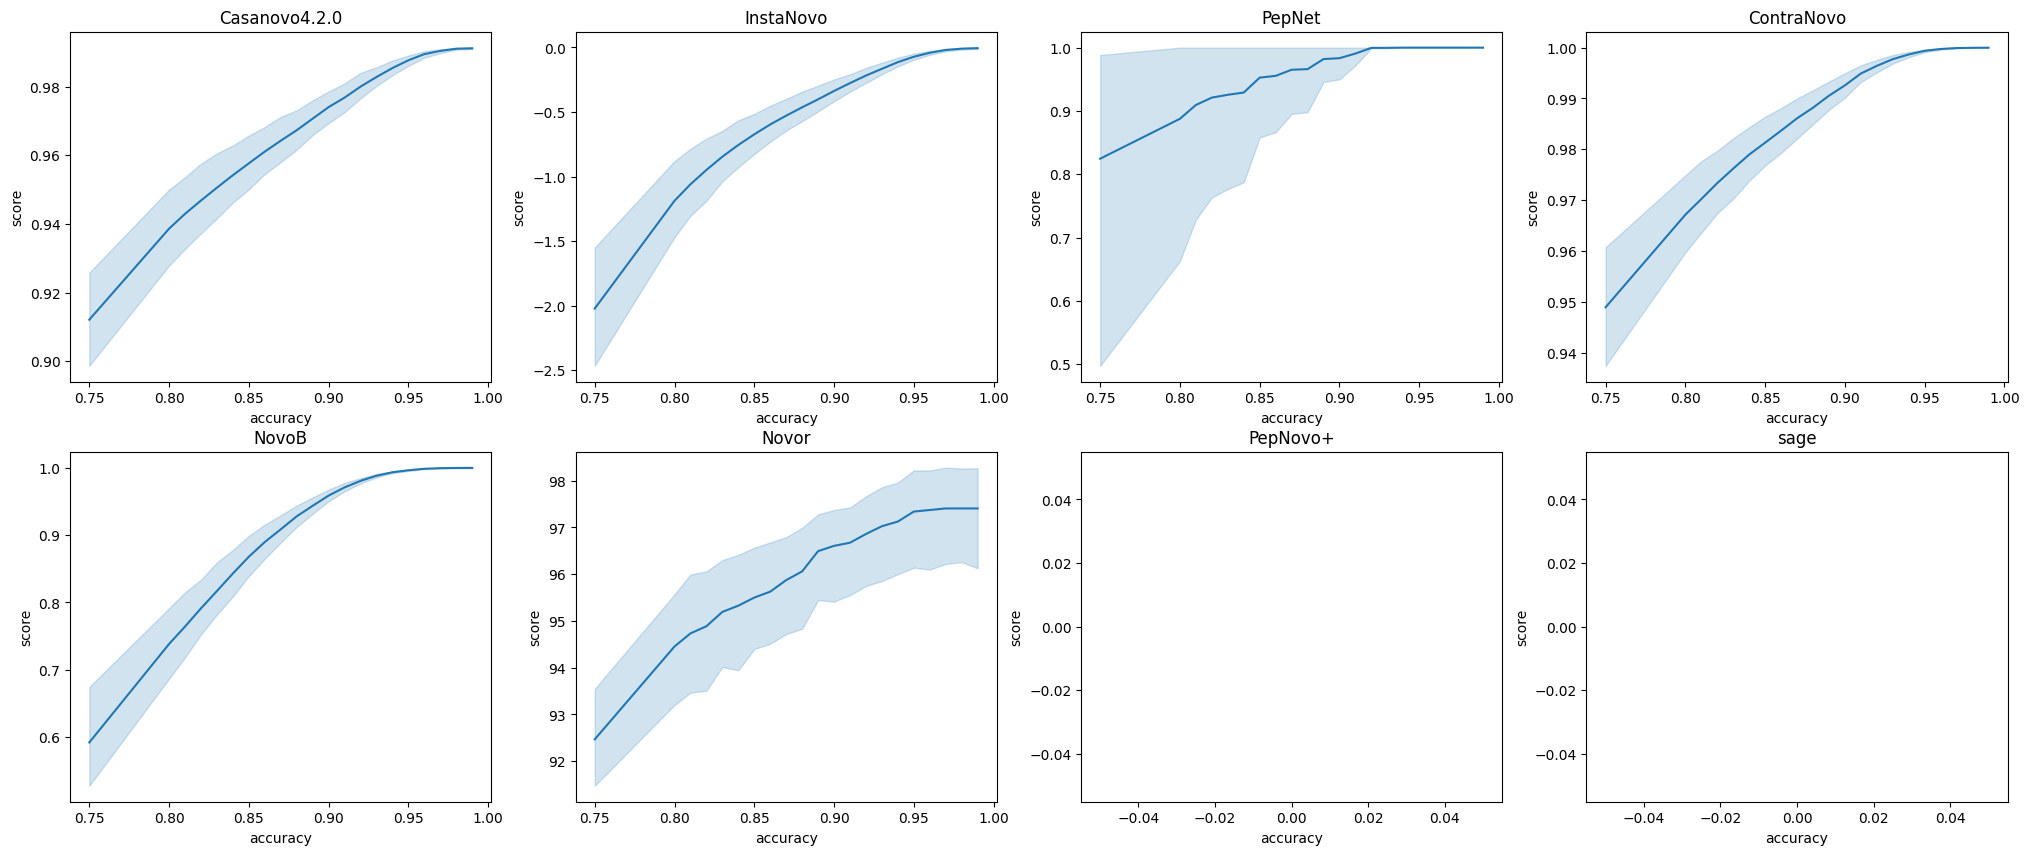

In [39]:
fig, ax = plt.subplots(2,4, figsize=(25,10))
x=0

metrics = {}
for y, engine in enumerate(df.source.unique()):
    if y>= 4:
        x=1
        y-=4

    sns.lineplot(
        accuracy_table[accuracy_table["engine"]==engine],
        x="accuracy",
        y="score",
        ax=ax[x][y]
    )
    ax[x][y].set_title(engine)


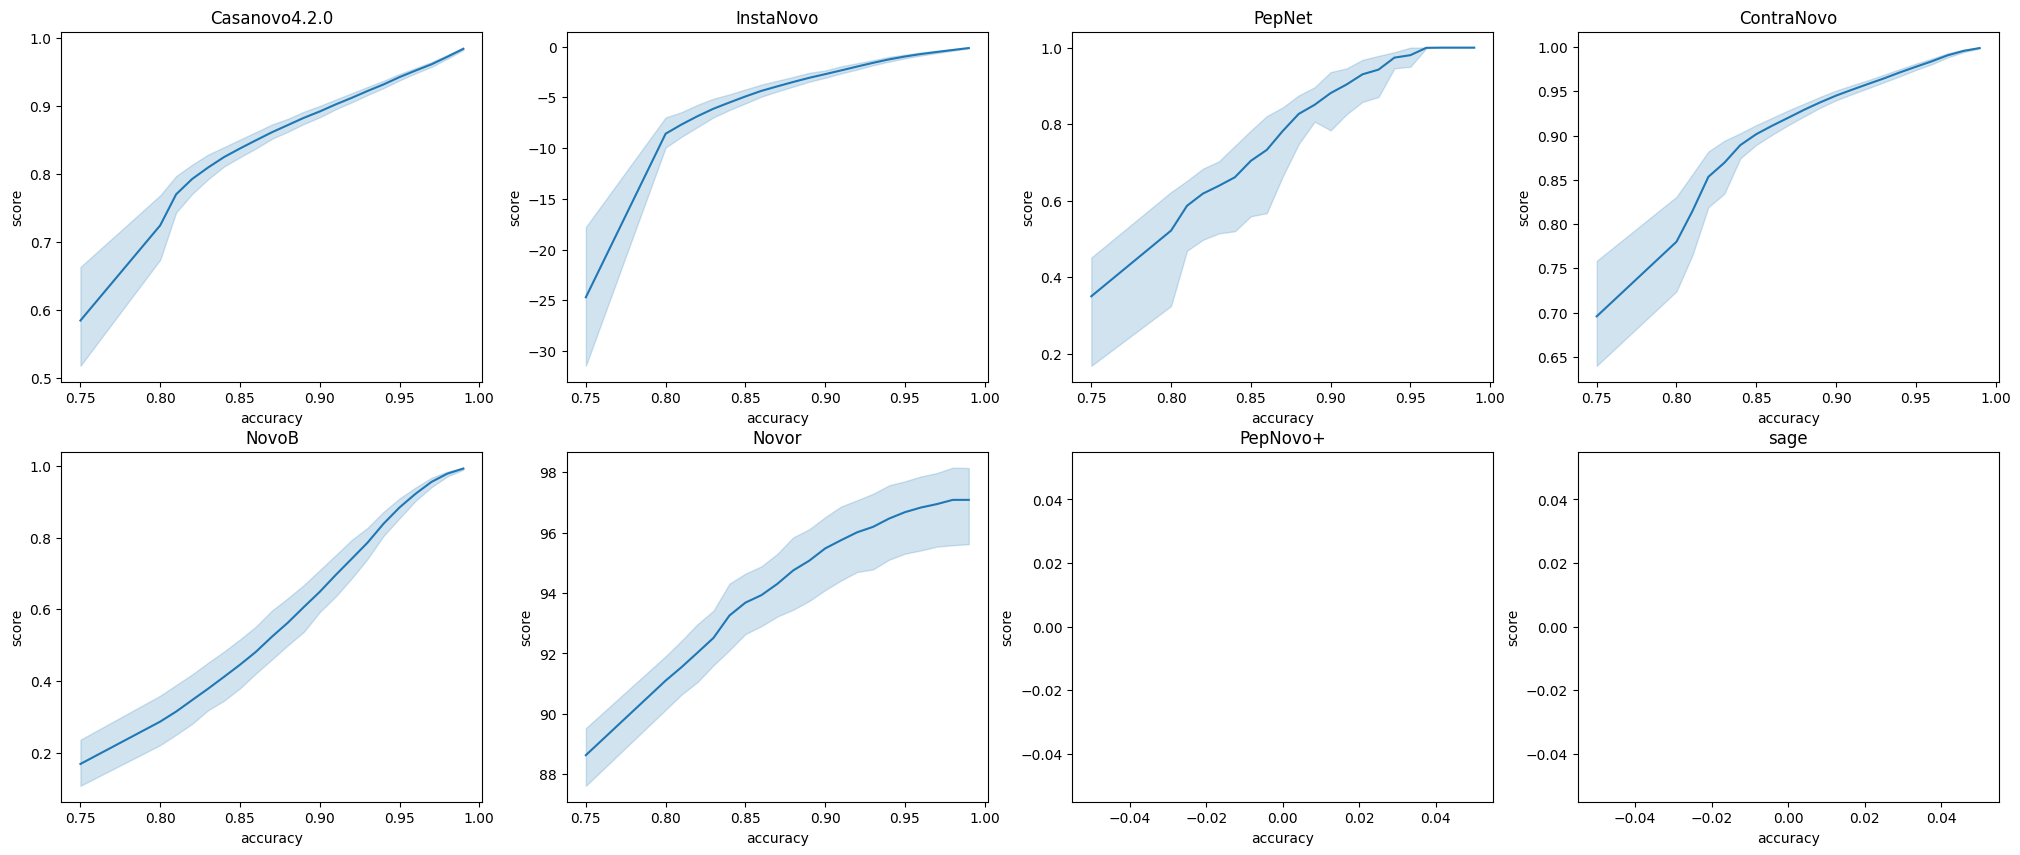

In [20]:
fig, ax = plt.subplots(2,4, figsize=(25,10))
x=0

metrics = {}
for y, engine in enumerate(df.source.unique()):
    if y>= 4:
        x=1
        y-=4

    sns.lineplot(
        accuracy_lenient_table[accuracy_lenient_table["engine"]==engine],
        x="accuracy",
        y="score",
        ax=ax[x][y]
    )
    ax[x][y].set_title(engine)

Spectralis scores

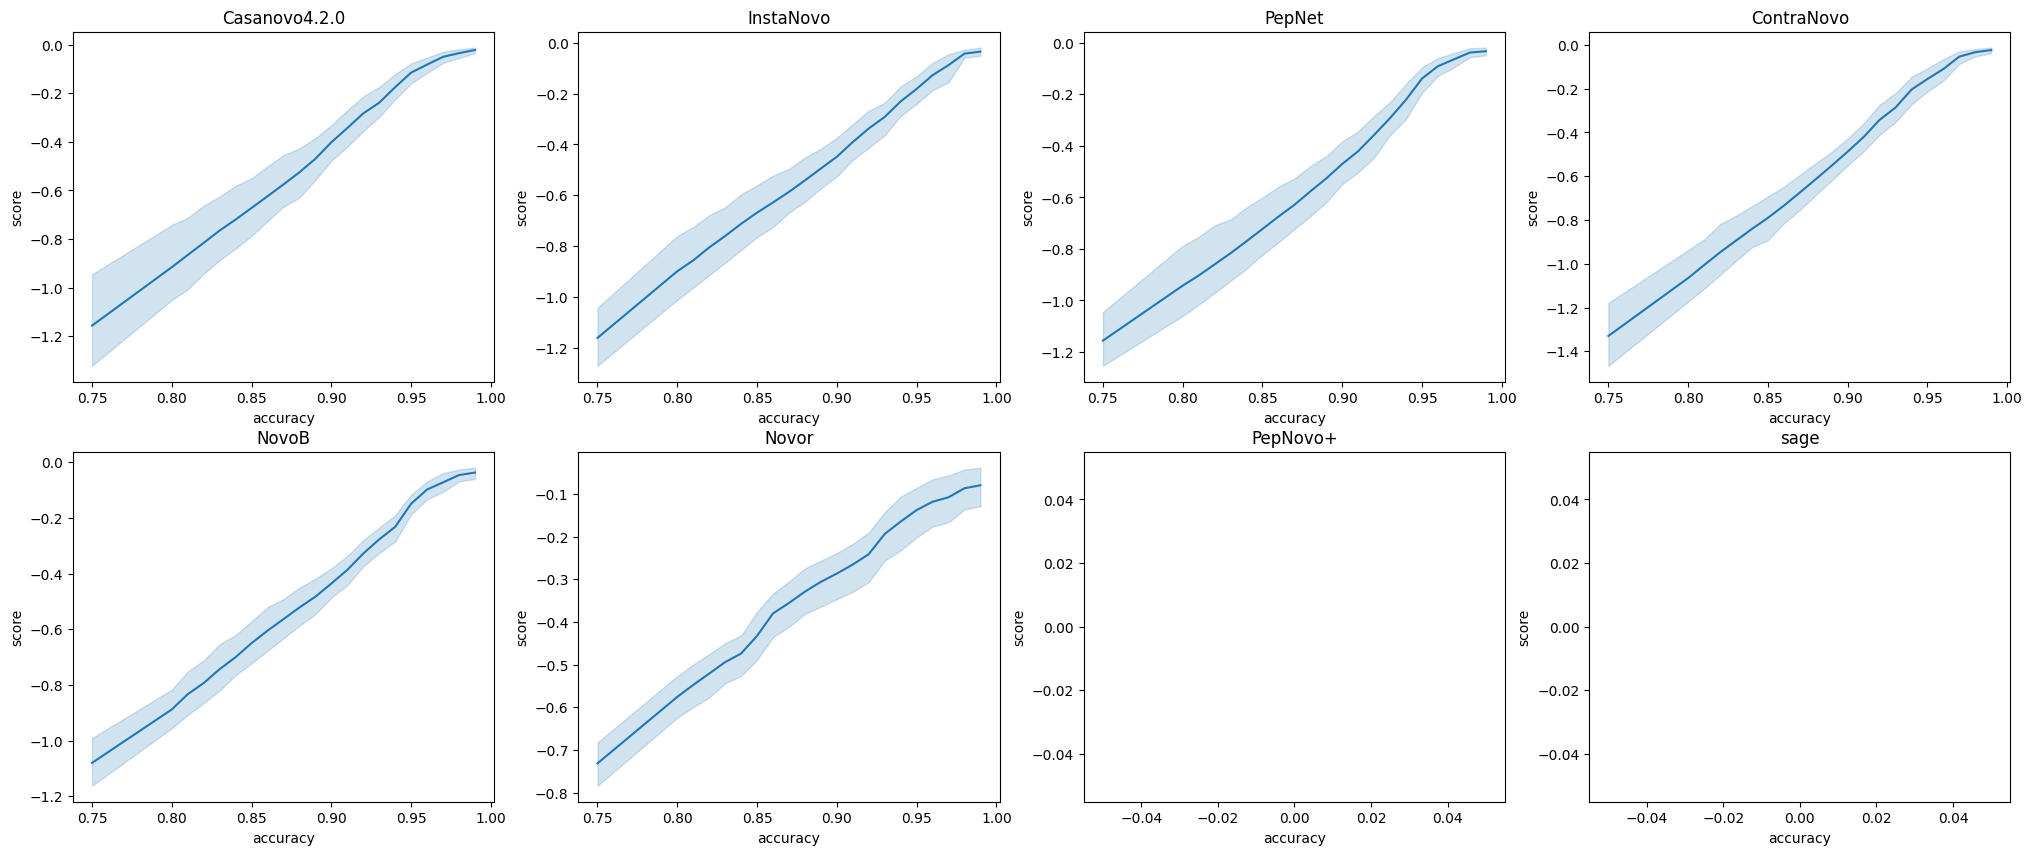

In [46]:
fig, ax = plt.subplots(2,4, figsize=(25,10))
x=0

metrics = {}
for y, engine in enumerate(df.source.unique()):
    if y>= 4:
        x=1
        y-=4

    sns.lineplot(
        accuracy_table[accuracy_table["engine"]==engine],
        x="accuracy",
        y="score",
        ax=ax[x][y]
    )
    ax[x][y].set_title(engine)


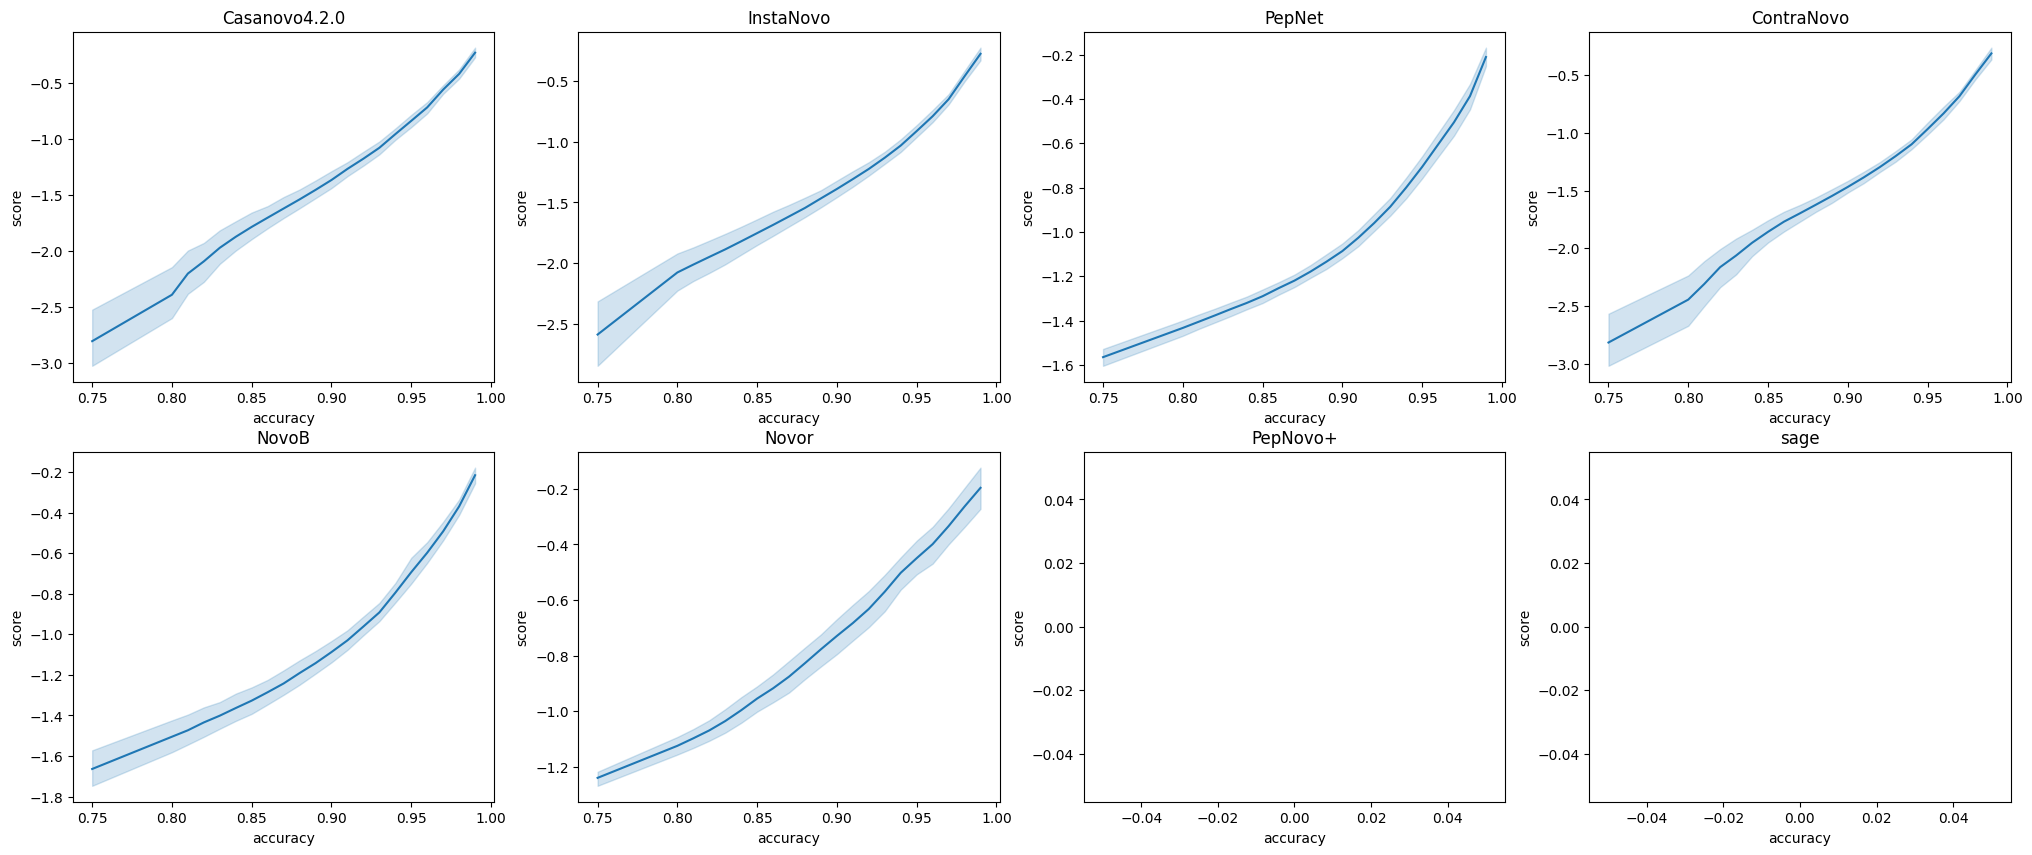

In [47]:
fig, ax = plt.subplots(2,4, figsize=(25,10))
x=0

metrics = {}
for y, engine in enumerate(df.source.unique()):
    if y>= 4:
        x=1
        y-=4

    sns.lineplot(
        accuracy_lenient_table[accuracy_lenient_table["engine"]==engine],
        x="accuracy",
        y="score",
        ax=ax[x][y]
    )
    ax[x][y].set_title(engine)


<Axes: xlabel='accuracy', ylabel='score'>

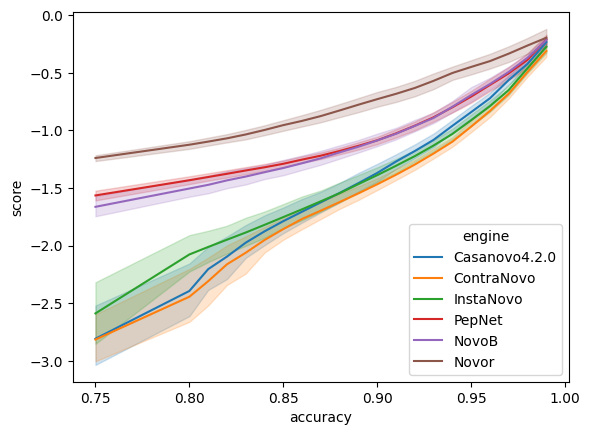

In [12]:
sns.lineplot(
    accuracy_lenient_table,
    x="accuracy",
    y="score",
    hue="engine"
)

<Axes: xlabel='accuracy', ylabel='score'>

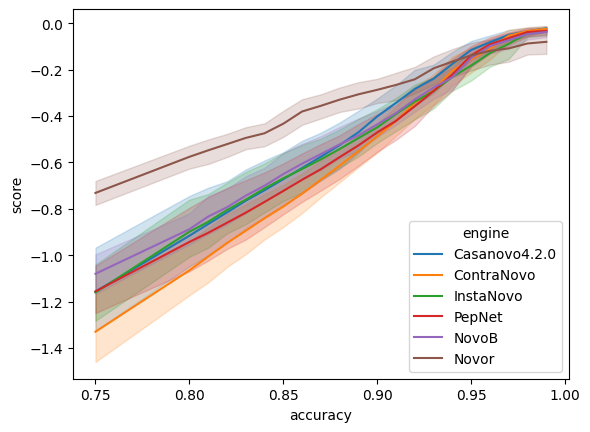

In [13]:
sns.lineplot(
    accuracy_table,
    x="accuracy",
    y="score",
    hue="engine"
)

<Axes: xlabel='accuracy', ylabel='coverage'>

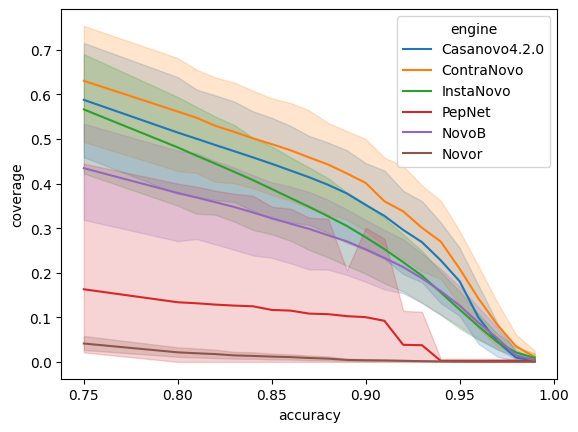

In [41]:
sns.lineplot(
    accuracy_table,
    x="accuracy",
    y="coverage",
    hue="engine"
)

<Axes: xlabel='accuracy', ylabel='coverage'>

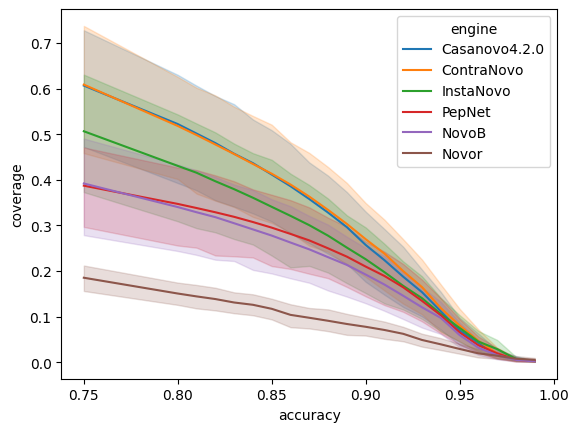

In [23]:
sns.lineplot(
    accuracy_table,
    x="accuracy",
    y="coverage",
    hue="engine"
)

<Axes: xlabel='accuracy', ylabel='recall'>

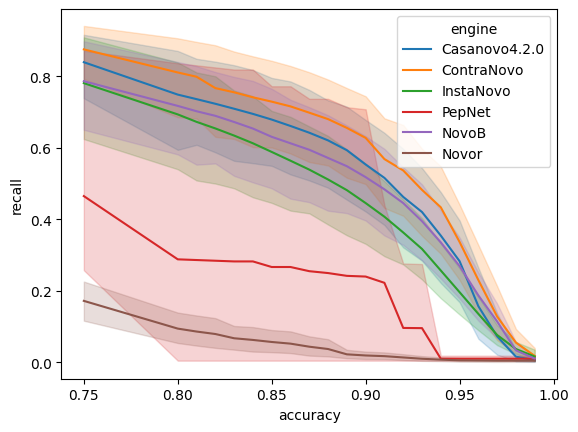

In [42]:
sns.lineplot(
    accuracy_table,
    x="accuracy",
    y="recall",
    hue="engine"
)

<Axes: xlabel='accuracy', ylabel='recall'>

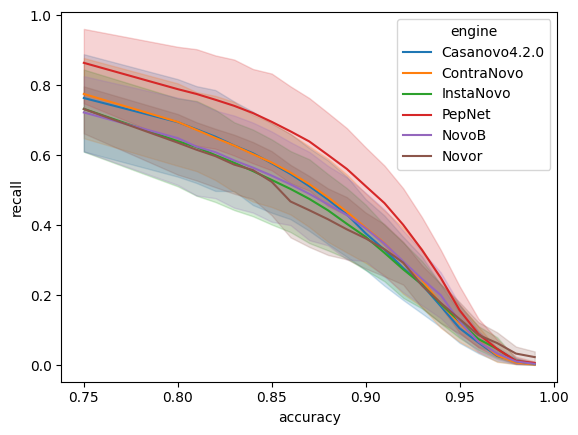

In [24]:
sns.lineplot(
    accuracy_table,
    x="accuracy",
    y="recall",
    hue="engine"
)

If the blue line falls below the orange one, this indicates that:
- The de novo score in absolute sense is overly conservative in defining accuracy
- Our lenient accuracy definition is too lenient

In [69]:
# Get scores for 95% accuracy

score_thresholds = {}
coverages = {}

for engine in accuracy_table.engine.unique():
    score_thresholds[engine] = accuracy_table.loc[
        (accuracy_table.accuracy==.95) &
        (accuracy_table.engine == engine),
        "score"
    ].tolist()
    coverages[engine] = accuracy_table.loc[
        (accuracy_table.accuracy==.95) &
        (accuracy_table.engine == engine),
        "coverage"
    ].tolist()

print("Coverage")
for engine, scores in coverages.items():
    m, std = np.mean(scores), np.std(scores)
    print("{}: \t{:.5f}\t{:.5f}".format(engine, m , std))

print()
print("Score thresholds")
for engine, scores in score_thresholds.items():
    m, std = np.mean(scores), np.std(scores)
    print("{}: \t{:.5f}\t{:.5f}".format(engine, m , std))

Coverage
Casanovo4.2.0: 	0.18125	0.16769
ContraNovo: 	0.20935	0.18161
InstaNovo: 	0.11784	0.09135
PepNet: 	0.00256	0.00307
NovoB: 	0.12672	0.09700
Novor: 	0.00098	0.00168

Score thresholds
Casanovo4.2.0: 	0.98763	0.00338
ContraNovo: 	0.99935	0.00061
InstaNovo: 	-0.07244	0.05488
PepNet: 	0.99990	0.00000
NovoB: 	0.99597	0.00221
Novor: 	97.34000	2.11622


In [9]:
# Get scores for 95% accuracy

score_thresholds = {}
coverages = {}

for engine in accuracy_lenient_table.engine.unique():
    score_thresholds[engine] = accuracy_lenient_table.loc[
        (accuracy_lenient_table.accuracy==.95) &
        (accuracy_lenient_table.engine == engine),
        "score"
    ].tolist()
    coverages[engine] = accuracy_lenient_table.loc[
        (accuracy_lenient_table.accuracy==.95) &
        (accuracy_lenient_table.engine == engine),
        "coverage"
    ].tolist()

print("Coverage")
for engine, scores in coverages.items():
    m, std = np.mean(scores), np.std(scores)
    print("{}: \t{:.5f}\t{:.5f}".format(engine, m , std))

print()
print("Score thresholds")
set_threshold = {}
for engine, scores in score_thresholds.items():
    m, std = np.mean(scores), np.std(scores)
    set_threshold[engine] = m
    print("{}: \t{:.5f}\t{:.5f}".format(engine, m , std))

Coverage
Casanovo4.2.0: 	0.50176	0.20977
ContraNovo: 	0.51989	0.20638
InstaNovo: 	0.44452	0.22561
PepNet: 	0.10746	0.13720
NovoB: 	0.30821	0.16917
Novor: 	0.00450	0.00936

Score thresholds
Casanovo4.2.0: 	0.94238	0.00993
ContraNovo: 	0.97773	0.00794
InstaNovo: 	-0.97295	0.40912
PepNet: 	0.98020	0.02175
NovoB: 	0.88425	0.05765
Novor: 	96.67333	2.41177


In [10]:
set_threshold

{'Casanovo4.2.0': 0.9423831251120693,
 'ContraNovo': 0.9777301218350248,
 'InstaNovo': -0.972949795817074,
 'PepNet': 0.9802,
 'NovoB': 0.8842544444444446,
 'Novor': 96.67333333333332}

In [11]:
proforma_seq_list = []
specid_all_list = []
specid_correct_list = []
specid_isobaric_list = []
specid_better_list = [] 


for p in tqdm(file_paths):
    proforma_seqs = {}
    specid_all = {}
    specid_correct = {}
    specid_isobaric = {}
    specid_better = {}

    df = pd.read_pickle(p)
    
    for engine, threshold in set_threshold.items():
        subset = df[
            (df.source == engine) &
            (df.score >= threshold)
        ]
        proforma_seqs[engine] = set(subset.peptide.tolist())
        specid_all[engine] = set(subset.spectrum_id.tolist())
        specid_correct[engine] = set(subset[subset.match_type=="Match"].spectrum_id.tolist())
        specid_isobaric[engine] = set(subset[subset.match_type=="Isobaric"].spectrum_id.tolist())
        specid_better[engine] = set(subset[subset.match_type=="Better"].spectrum_id.tolist())
    
    proforma_seqs["sage"] = set(df.loc[df.source=="sage", "peptide"].tolist())
    proforma_seq_list.append(proforma_seqs)
    specid_all_list.append(specid_all)
    specid_correct_list.append(specid_correct)
    specid_isobaric_list.append(specid_isobaric)
    specid_better_list.append(specid_better)

100%|██████████| 21/21 [01:30<00:00,  4.32s/it]


In [12]:
from upsetplot import from_contents, plot

In [139]:
data = from_contents(proforma_seqs)

{'matrix': <Axes: >,
 'shading': <Axes: >,
 'totals': <Axes: >,
 'intersections': <Axes: ylabel='Intersection size'>}

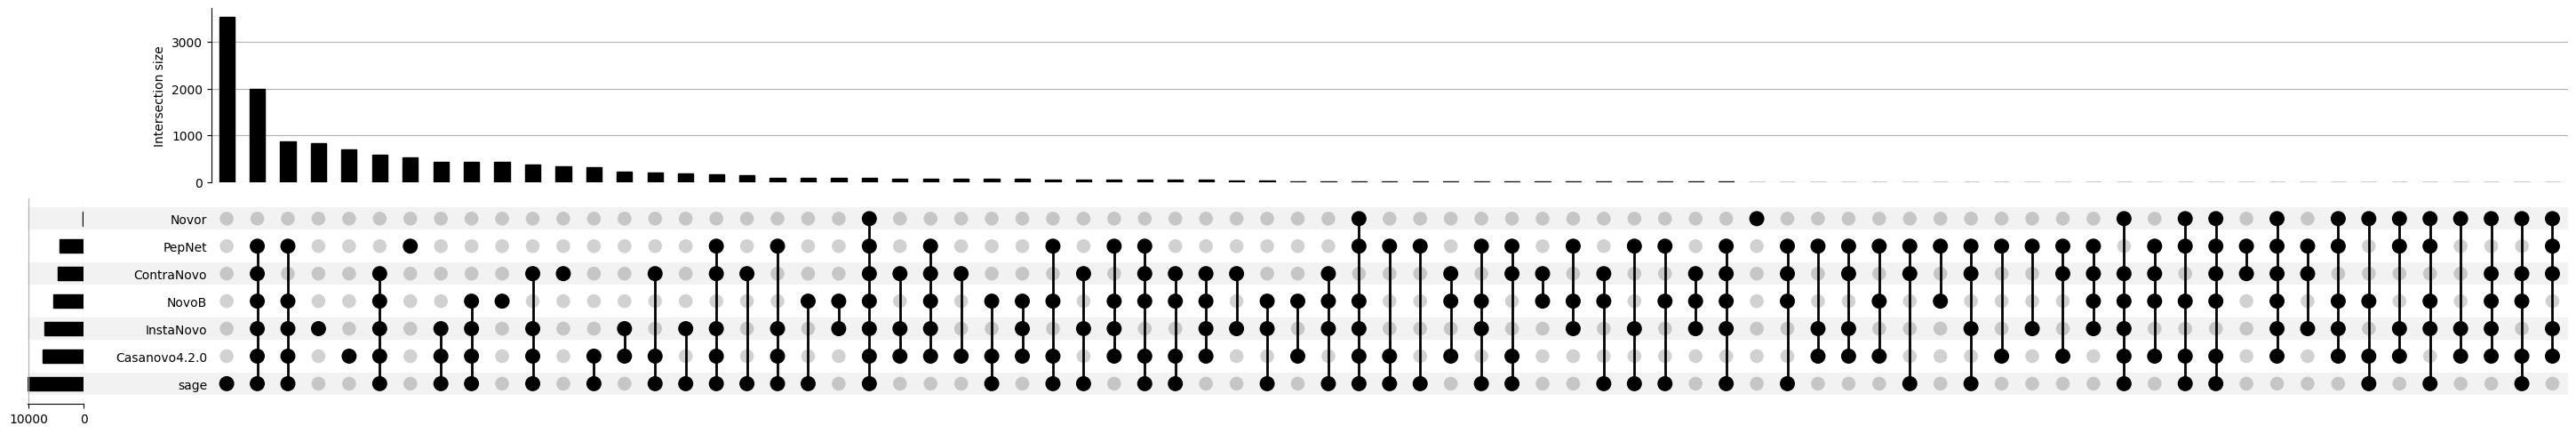

In [140]:
plot(data, sort_by="cardinality")

{'matrix': <Axes: >,
 'shading': <Axes: >,
 'totals': <Axes: >,
 'intersections': <Axes: ylabel='Intersection size'>}

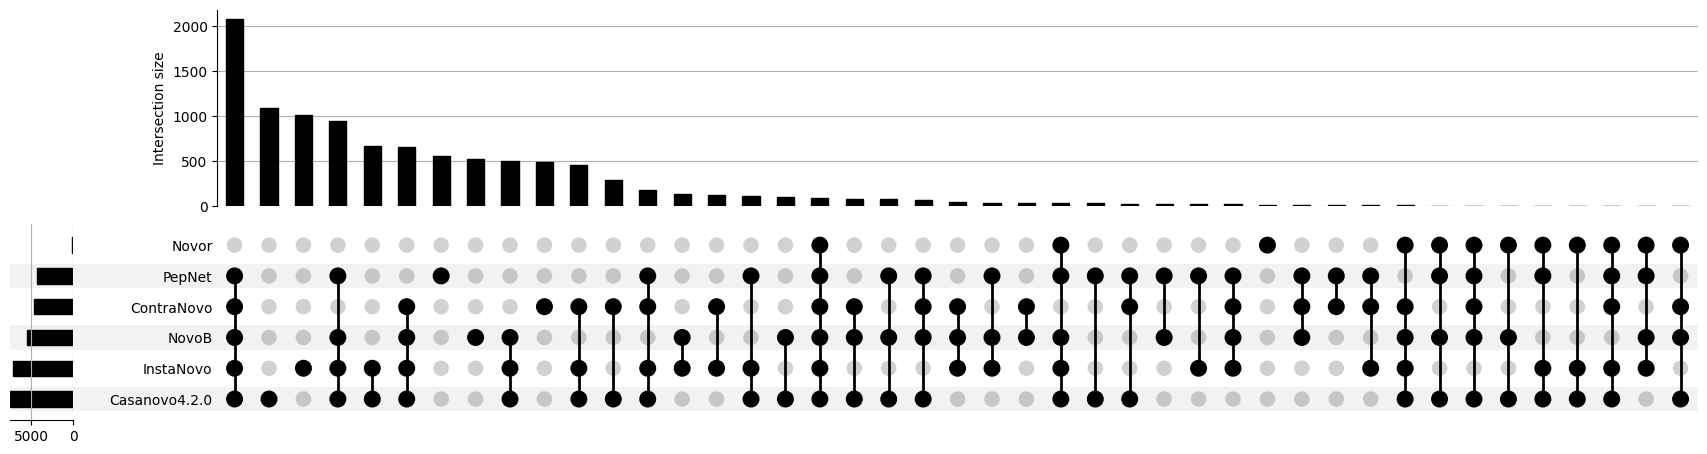

In [93]:
plot(data, sort_by="cardinality")

In [22]:
def plot_venn3(list_to_compare):
    fig, ax = plt.subplots(1,3,figsize=(18,5))

    venn3(
        subsets=(
            set(list_to_compare["Casanovo4.2.0"]),
            set(list_to_compare["InstaNovo"]),
            set(list_to_compare["NovoB"])
        ),
        set_labels=(
            "Casanovo",
            "Instanovo",
            "NovoB"
        ),
        ax=ax[0]
    )

    venn3(
        subsets=(
            set(list_to_compare["ContraNovo"]),
            set(list_to_compare["NovoB"]),
            set(list_to_compare["PepNet"])
        ),
        set_labels=(
            "Contranovo",
            "novob",
            "PepNet"
        ),
        ax=ax[2]
    )

    venn3(
        subsets=(
            set(list_to_compare["ContraNovo"]),
            set(list_to_compare["Casanovo4.2.0"]),
            set(list_to_compare["PepNet"])
        ),
        set_labels=(
            "Contranovo",
            "Casanovo4.2.0",
            "PepNet"
        ),
        ax=ax[1]
    )

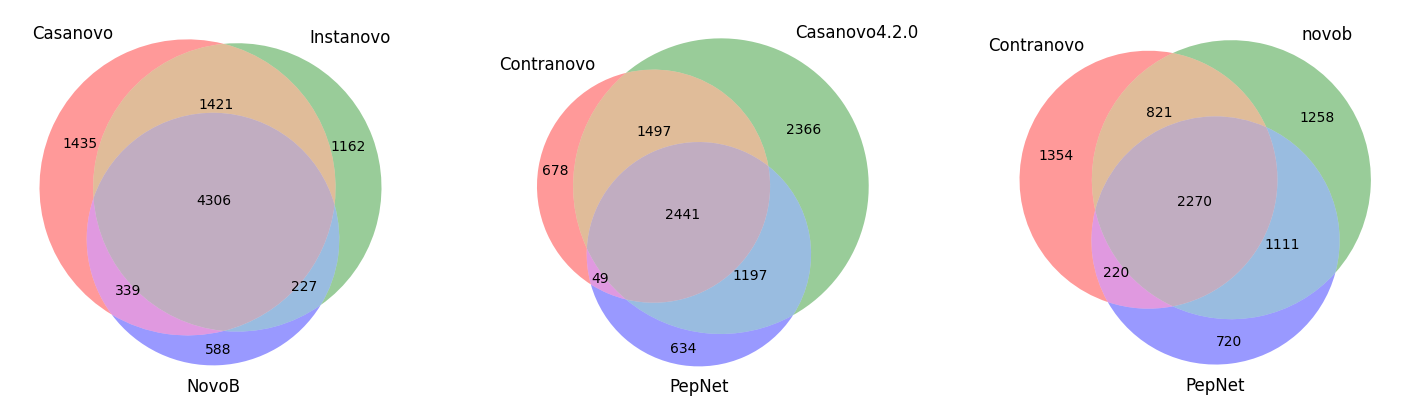

In [106]:
from matplotlib_venn import venn3

fig, ax = plt.subplots(1,3,figsize=(18,5))

venn3(
    subsets=(
        set(proforma_seqs["Casanovo4.2.0"]),
        set(proforma_seqs["InstaNovo"]),
        set(proforma_seqs["NovoB"])
    ),
    set_labels=(
        "Casanovo",
        "Instanovo",
        "NovoB"
    ),
    ax=ax[0]
)

venn3(
    subsets=(
        set(proforma_seqs["ContraNovo"]),
        set(proforma_seqs["NovoB"]),
        set(proforma_seqs["PepNet"])
    ),
    set_labels=(
        "Contranovo",
        "novob",
        "PepNet"
    ),
    ax=ax[2]
)

venn3(
    subsets=(
        set(proforma_seqs["ContraNovo"]),
        set(proforma_seqs["Casanovo4.2.0"]),
        set(proforma_seqs["PepNet"])
    ),
    set_labels=(
        "Contranovo",
        "Casanovo4.2.0",
        "PepNet"
    ),
    ax=ax[1]
)

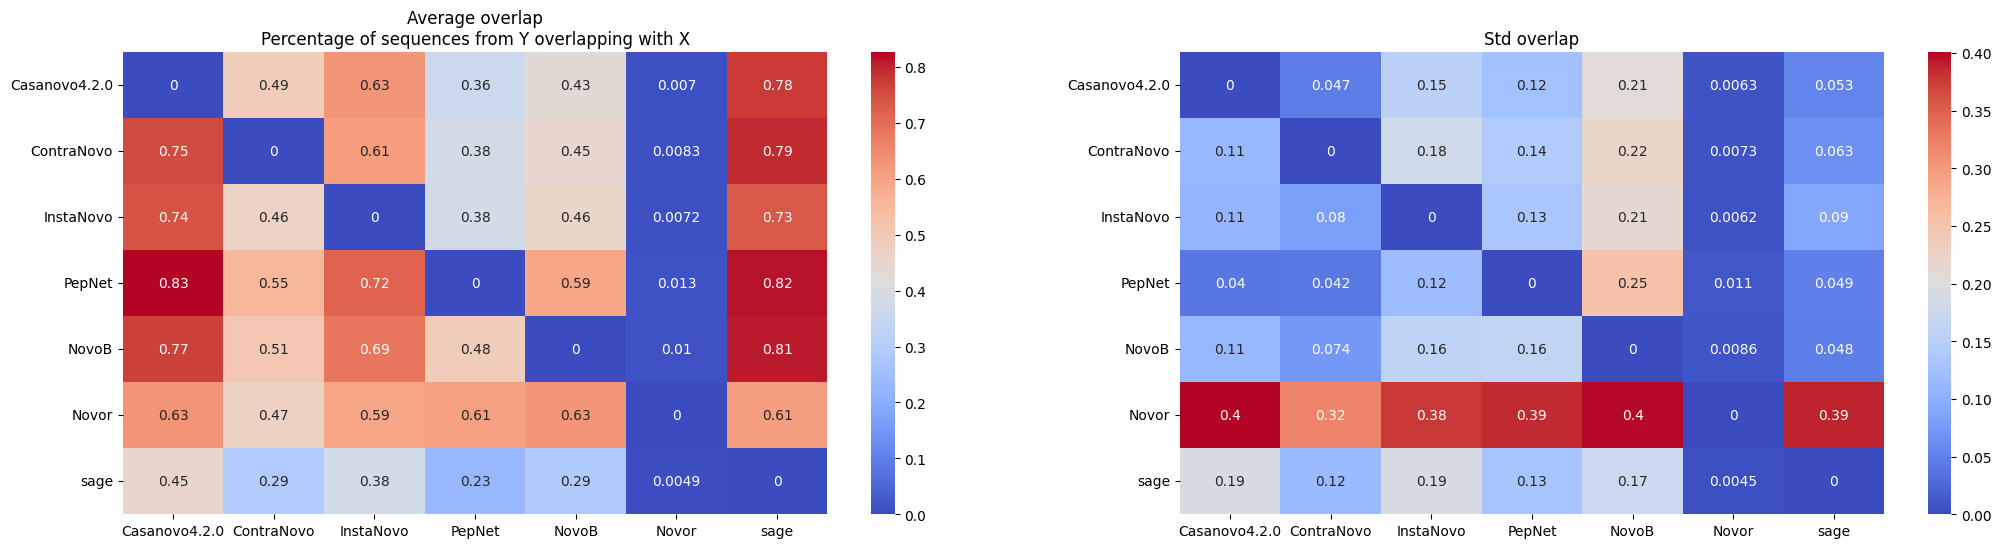

In [15]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def get_overlap(list1, list2):
    set_1, set_2 = set(list1), set(list2)
    intersection = set_1.intersection(set_2)

    if len(set_1) == 0:
        overlap_tool_1 = 0
    else:
        overlap_tool_1 = len(intersection) / len(set_1)
    if len(set_2) == 0:
        overlap_tool_2 = 0
    else:
        overlap_tool_2 = len(intersection) / len(set_2)

    return overlap_tool_1, overlap_tool_2

def compute_pairwise_overlap(list_of_dicts):
    tools = list(list_of_dicts[0].keys())  # List of tool names
    num_tools = len(tools)

    # Initialize matrices to store mean and std
    mean_matrix = np.zeros((num_tools, num_tools))
    std_matrix = np.zeros((num_tools, num_tools))

    # Iterate over each pair of tools
    for i in range(num_tools):
        for j in range(i + 1, num_tools):
            overlaps = []

            # Compute overlaps across all datasets for this tool pair
            for d in list_of_dicts:
                overlap_1, overlap_2 = get_overlap(d[tools[i]], d[tools[j]])
                overlaps.append((overlap_1, overlap_2))

            # Calculate mean and std of overlaps
            mean_overlap_1, mean_overlap_2 = np.mean([i[0] for i in overlaps]), np.mean([i[1] for i in overlaps])
            std_overlap_1, std_overlap_2 = np.std([i[0] for i in overlaps]), np.std([i[1] for i in overlaps])

            # Fill the matrices
            mean_matrix[i, j] = mean_overlap_1
            mean_matrix[j, i] = mean_overlap_2

            std_matrix[i, j] = std_overlap_1
            std_matrix[j, i] = std_overlap_2

    return tools, mean_matrix, std_matrix

def plot_heatmap(tools, mean_matrix, std_matrix):
    num_tools = len(tools)

    # Create a mask for the upper triangle
    # mask = np.zeros_like(mean_matrix)
    # mask[np.tril_indices_from(mask)] = True

    # # Create a combined matrix for plotting
    # combined_matrix = np.zeros((num_tools, num_tools))
    # combined_matrix[np.triu_indices(num_tools, 1)] = mean_matrix[np.triu_indices(num_tools, 1)]
    # combined_matrix[np.tril_indices(num_tools, -1)] = std_matrix[np.tril_indices(num_tools, -1)]

    # Set up the matplotlib figure
    fig, ax = plt.subplots(1, 2, figsize=(25, 6))

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(mean_matrix, annot=True, cmap="coolwarm", xticklabels=tools, yticklabels=tools, ax=ax[0])
    sns.heatmap(std_matrix, annot=True, cmap="coolwarm", xticklabels=tools, yticklabels=tools, ax=ax[1])

    # Add titles and labels
    ax[0].set_title("Average overlap\nPercentage of sequences from Y overlapping with X")

    ax[1].set_title("Std overlap")

# Example usage
# Assume you have n dictionaries in a list, where each dictionary contains peptide sequences for each tool
# list_of_dicts = [{'Tool1': [...], 'Tool2': [...], ...}, {'Tool1': [...], 'Tool2': [...], ...}, ...]

# Replace this with actual data


tools, mean_matrix, std_matrix = compute_pairwise_overlap(proforma_seq_list)
plot_heatmap(tools, mean_matrix, std_matrix)

In [16]:
len_seqs = []

for tool_seqs in proforma_seq_list:
    len_seqs.append({tool: len(seqs) for tool, seqs in tool_seqs.items()})

coverages = []
for tool_seqs in len_seqs:
    coverages.append({tool: tool_seqs[tool]/tool_seqs["sage"] for tool in tool_seqs.keys()})

<Axes: >

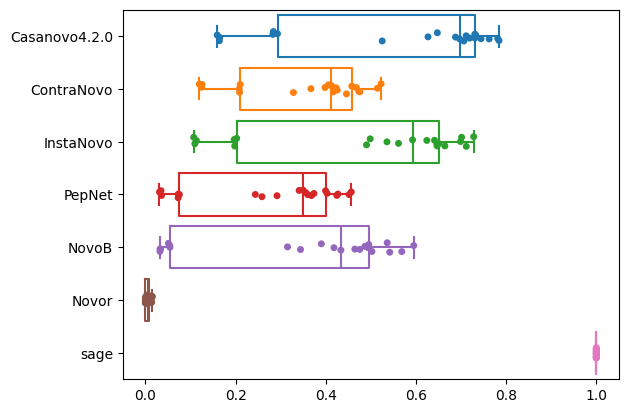

In [17]:
sns.stripplot(pd.DataFrame(coverages), orient="h")
sns.boxplot(pd.DataFrame(coverages), orient="h", fill=False)

## Check for correct predictions, what the overlap is between tools

Question to answer: If a tool is correct, are the others as well on the same spectra? Or do they perform well on different spectra?

Question 2: If the tools are wrong, do the tools still corroborate with each other?

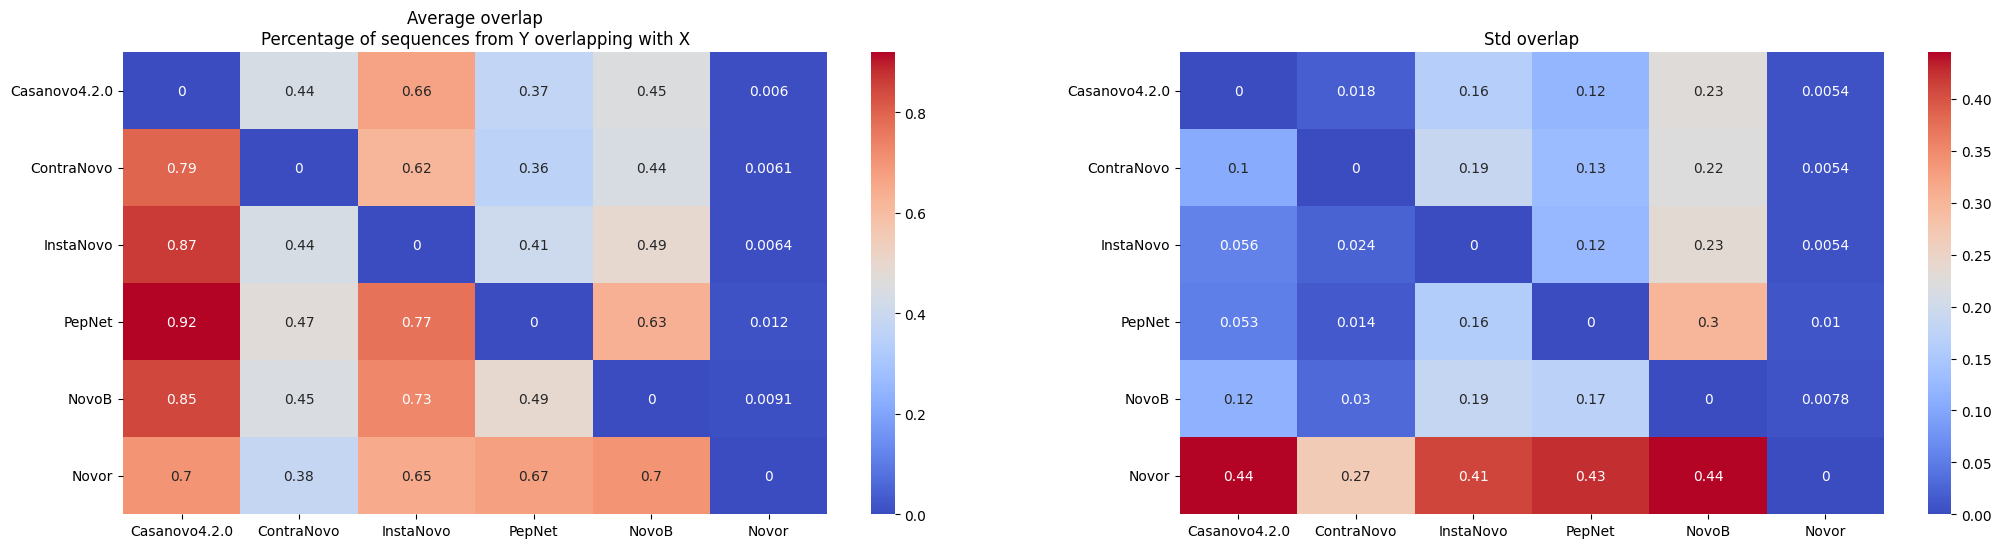

In [19]:
tools, mean_matrix, std_matrix = compute_pairwise_overlap(specid_correct_list)
plot_heatmap(tools, mean_matrix, std_matrix)

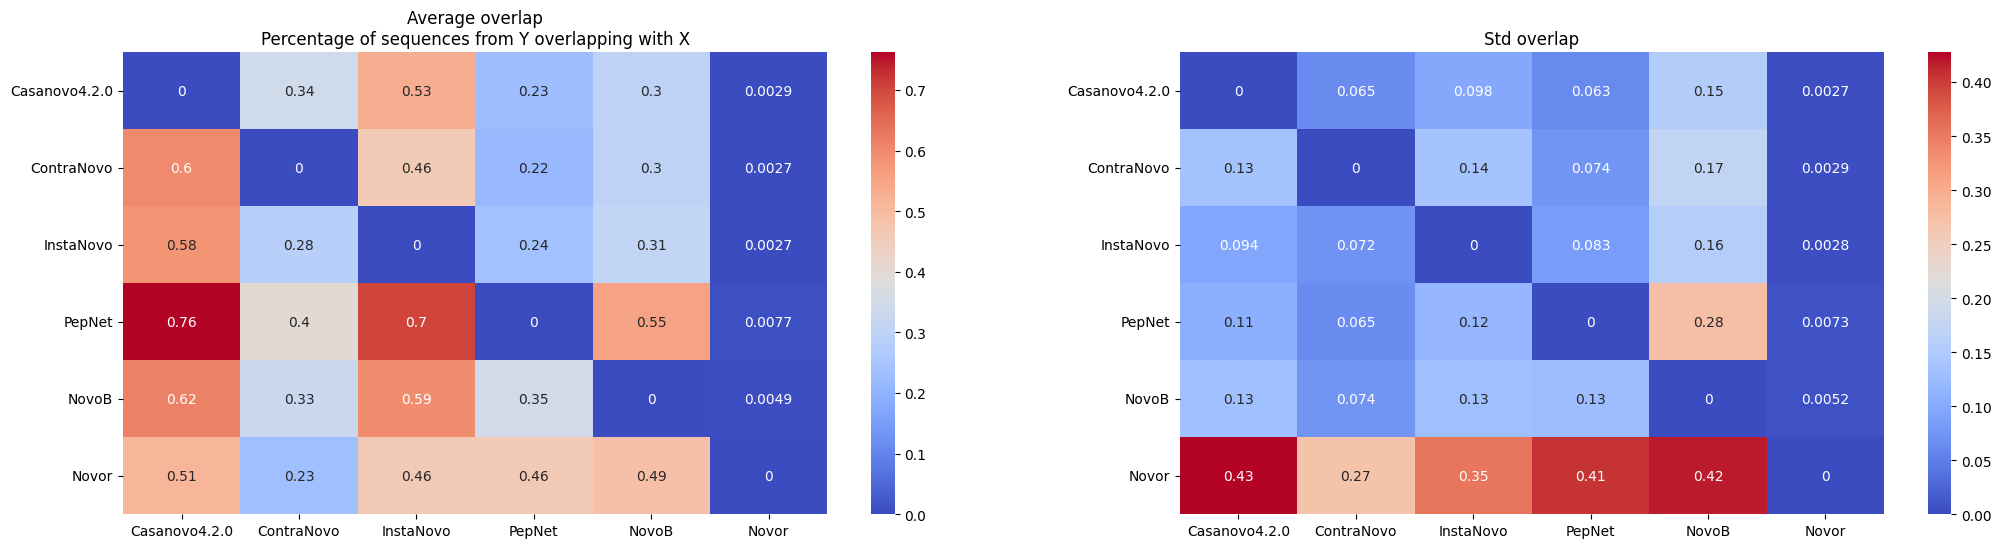

In [20]:
tools, mean_matrix, std_matrix = compute_pairwise_overlap(specid_better_list)
plot_heatmap(tools, mean_matrix, std_matrix)

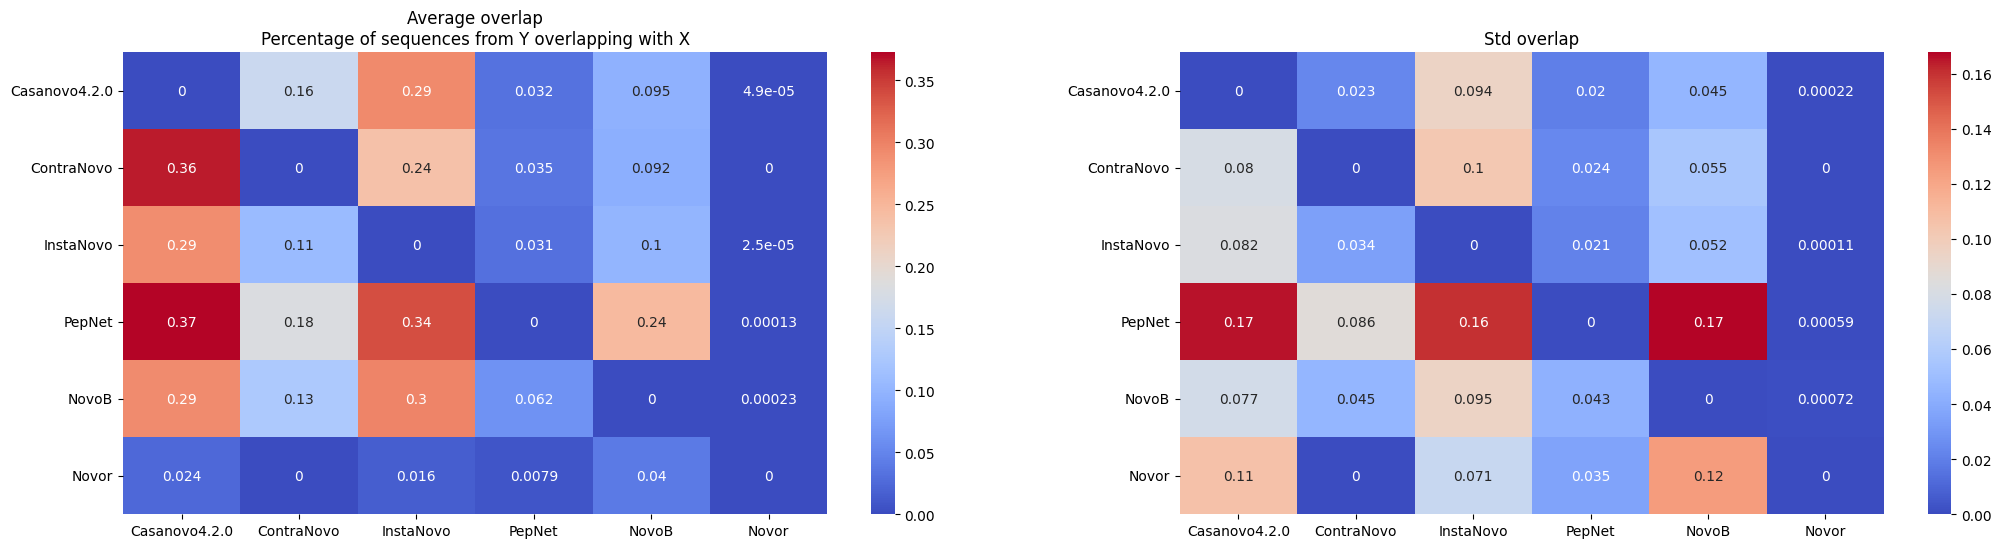

In [21]:
tools, mean_matrix, std_matrix = compute_pairwise_overlap(specid_isobaric_list)
plot_heatmap(tools, mean_matrix, std_matrix)

Overlap of PepNet is highest with identifications from other tools in general, however at a very low recall. This means that PepNet in general outputs way less predictions at the provided accuracy threshold but if it does, it seems to corroborate well with what is true.

However, filtering was here done on the lenient accuracy -> isobaric and higher hyperscores are considered true

What is the overlap of these regardless of the sage output -> not direct match but do they corroborate well amongst each others ?

## Are there differences between characteristics of peptides correctly predicted between tools?

Example answer:
- Tool 1 is better at correctly predicting higher charge states
- Tool 2 is better at correctly predicting longer sequences
- Tool 3 is better at handling noisy spectra
- Tool 4 is better at predicting spectra with less ion coverage

What is difference between spectra correclty vs wrongly predicted? Is there difference between tools of this difference? --> Assumes different spectra are well predicted which seems to be the case in some sense

In [13]:
psmlists = []

for p in tqdm(glob("/home/samva/Doctorate/data_directory/denovo_project/denovo_results/sage/*.sage.tsv")):

    parser = DenovoEngineConverter.select("sage")
    psmlist = parser.parse(result_path=p, mgf_path="")
    psmlist = psmlist[psmlist["is_decoy"]]
    psmlist = psmlist[psmlist["qvalue"] < .01]
    psmlists.append(psmlist)

100%|██████████| 23/23 [02:17<00:00,  5.99s/it]


In [32]:
specids_correct_dict = {filename.split("/")[-1].split(".")[0]: specids for filename, specids in zip(file_paths, specid_correct_list)}
psmlists_dict = {pl[0].run: pl for pl in psmlists}

In [7]:
metrics_score = get_precision_coverage_df(
    df,
    source="Casanovo4.2.0",
    score_col="score",
    correctness_col="correct_prediction",
    ground_truth_source="sage"
)
metrics_spectralis = get_precision_coverage_df(
    df,
    source="Casanovo4.2.0",
    score_col="spectralis_score",
    correctness_col="correct_prediction",
    ground_truth_source="sage"
)
metrics_hyperscore = get_precision_coverage_df(
    df,
    source="Casanovo4.2.0",
    score_col="hyperscore",
    correctness_col="correct_prediction",
    ground_truth_source="sage"
)

metrics_score_lenient = get_precision_coverage_df(
    df,
    source="Casanovo4.2.0",
    score_col="score",
    correctness_col="correct_prediction_lenient",
    ground_truth_source="sage"
)
metrics_spectralis_lenient = get_precision_coverage_df(
    df,
    source="Casanovo4.2.0",
    score_col="spectralis_score",
    correctness_col="correct_prediction_lenient",
    ground_truth_source="sage"
)
metrics_hyperscore_lenient = get_precision_coverage_df(
    df,
    source="Casanovo4.2.0",
    score_col="hyperscore",
    correctness_col="correct_prediction_lenient",
    ground_truth_source="sage"
)

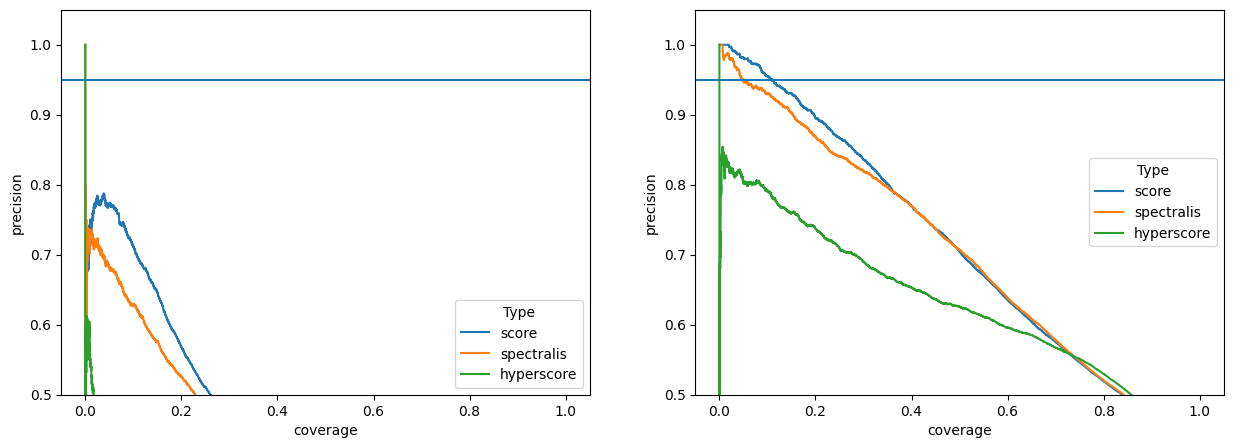

In [8]:
fig, ax = plt.subplots(1,2, figsize=(15,5))
sns.lineplot(
    metrics_score,
    x="coverage",
    y="precision",
    label="score",
    ax=ax[0]
)
sns.lineplot(
    metrics_spectralis,
    x="coverage",
    y="precision",
    label="spectralis",
    ax=ax[0]
)
sns.lineplot(
    metrics_hyperscore,
    x="coverage",
    y="precision",
    label="hyperscore",
    ax=ax[0]
)


sns.lineplot(
    metrics_score_lenient,
    x="coverage",
    y="precision",
    label="score",
    ax=ax[1]
)
sns.lineplot(
    metrics_spectralis_lenient,
    x="coverage",
    y="precision",
    label="spectralis",
    ax=ax[1]
)
sns.lineplot(
    metrics_hyperscore_lenient,
    x="coverage",
    y="precision",
    label="hyperscore",
    ax=ax[1]
)

ax[0].set_ylim((.5, 1.05))
ax[0].set_xlim((-.05, 1.05))
ax[0].legend(title="Type")
ax[0].axhline(.95)

ax[1].set_ylim((.5, 1.05))
ax[1].set_xlim((-.05, 1.05))
ax[1].legend(title="Type")
ax[1].axhline(.95)

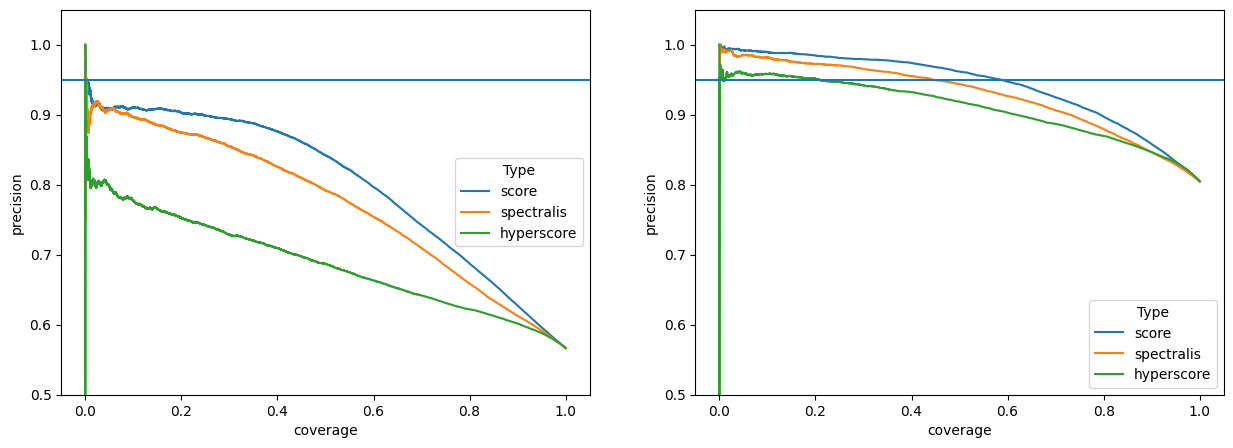

In [82]:
fig, ax = plt.subplots(1,2, figsize=(15,5))
sns.lineplot(
    metrics_score,
    x="coverage",
    y="precision",
    label="score",
    ax=ax[0]
)
sns.lineplot(
    metrics_spectralis,
    x="coverage",
    y="precision",
    label="spectralis",
    ax=ax[0]
)
sns.lineplot(
    metrics_hyperscore,
    x="coverage",
    y="precision",
    label="hyperscore",
    ax=ax[0]
)


sns.lineplot(
    metrics_score_lenient,
    x="coverage",
    y="precision",
    label="score",
    ax=ax[1]
)
sns.lineplot(
    metrics_spectralis_lenient,
    x="coverage",
    y="precision",
    label="spectralis",
    ax=ax[1]
)
sns.lineplot(
    metrics_hyperscore_lenient,
    x="coverage",
    y="precision",
    label="hyperscore",
    ax=ax[1]
)

ax[0].set_ylim((.5, 1.05))
ax[0].set_xlim((-.05, 1.05))
ax[0].legend(title="Type")
ax[0].axhline(.95)

ax[1].set_ylim((.5, 1.05))
ax[1].set_xlim((-.05, 1.05))
ax[1].legend(title="Type")
ax[1].axhline(.95)

In [ ]:
# Acquire for a given accuracy threshold:
# - Coverage
# - Recall
# - Lowest de novo score

# And for lenient matches
# - % accuracy
# - % better
# - % Worse
# - % Isobaric

In [140]:
def get_threshold(df, threshold=.9):

    for i, precision in enumerate(df.precision.to_numpy()):
        if precision > threshold:
            return i
    
def profile_accuracy_thresholds(
    df,
    engine,
    thresholds = [.99, .95, .9, .85, .8]
):
    df_subset = df[
        df.source==engine
    ].sort_values("score")
    
    df["correct_prediction"] = df["match_type"].apply(lambda x: x=="Match")
    df["correct_prediction_lenient"] = df["match_type"].apply(lambda x: x!="Worse")
    metrics_score = get_precision_coverage_df(
        df,
        source=engine,
        score_col="score",
        correctness_col="correct_prediction",
        ground_truth_source="sage"
    )
    metrics_lenient = get_precision_coverage_df(
        df,
        source=engine,
        score_col="score",
        correctness_col="correct_prediction",
        ground_truth_source="sage"
    )
    
    score_profile = {"Accuracy": {}, "Accuracy_lenient": {}}
    for threshold in tqdm(thresholds):
        threshold_profile = {}
        threshold_profile_lenient = {}

        iloc_threshold = get_threshold(df=metrics_score, threshold=threshold)
        iloc_threshold_lenient = get_threshold(df=metrics_score_lenient, threshold=threshold)

        threshold_profile["recall"] = metrics_score.iloc[iloc_threshold]["recall"]
        threshold_profile["coverage"] = metrics_score.iloc[iloc_threshold]["coverage"]
        threshold_profile["score"] = df_subset.iloc[iloc_threshold]["score"]
        
        threshold_profile_lenient["recall"] = metrics_lenient.iloc[iloc_threshold_lenient]["recall"]
        threshold_profile_lenient["coverage"] = metrics_lenient.iloc[iloc_threshold_lenient]["coverage"]
        threshold_profile_lenient["score"] = df_subset.iloc[iloc_threshold_lenient]["score"]
        partition = df_subset.iloc[iloc_threshold_lenient:]["match_type"].value_counts(normalize=True)
        for match_type in ["Match", "Better", "Worse", "Isobaric"]:
            try:
                threshold_profile_lenient[match_type] = partition[match_type]
            except KeyError:
                threshold_profile_lenient[match_type] = 0.0
    
        score_profile["Accuracy"][threshold] = threshold_profile
        score_profile["Accuracy_lenient"][threshold] = threshold_profile_lenient
    return score_profile